<a href="https://colab.research.google.com/github/mirsci/graphrag-python-examples/blob/main/Using_OpenAI_o1_Reasoning_To_Generate_Routines_For_Agentic_AI_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Using OpenAI o1 Reasoning To Generate Routines For Agentic AI Systems**

In this notebook we'll use OpenAI's new o1 reasoning model to create 'routines' from a toy dataset of knowledge articles.

By doing so, this Colab notebook will demonstrate how o1 can generate highly detailed, and accurate step-by-step processes which can potentially used by other AI agents powered by other AI models (e.g. GPT4o-mini) to:

*   Create main and sub-action processes

*   Handle natural language queries, with appropriate conditional routing (e.g. asking a user for requisite clarifications or supplementary information)

*   Write steps to call functions from internal systems (e.g., `call the check_delivery_date function`).

*   Define new functions (with requisite parameters) to either pass actions to humans in the loop, or if possible, have the AI assistant perform it on the behalf of the user.

**Connect with Me**

If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/


### **Original Source (Please Read)**

I highly recommend checking out the original article by Roy Ziv at OpenAI.

This Colab notebook is almost entirely based on that bar from a few quality of life tweaks to make it accessible to people who like to run stuff in Colab (me).

*   OpenAI Cookbook Article: https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation


*   Github repo link: https://github.com/openai/openai-cookbook/blob/main/examples/o1/Using_reasoning_for_routine_generation.ipynb

## **Step1: Installs OpenAI python library**

First we need to install the OpenAI python Library

In [1]:
#installs
!pip install openai --quiet

## **Step 2: Set Your OpenAI Key**

To use this notebook and build your solution you will need...


*   An OpenAI user account and API Key (with billing set up)
*   Access to the o1 models (this may or may not be available to you yet)
*   As pictured below add this to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name
*   Key name: openai_key
*   Once that is done, run the below cell[link text](https://), granting key access to the notebook access if prompted




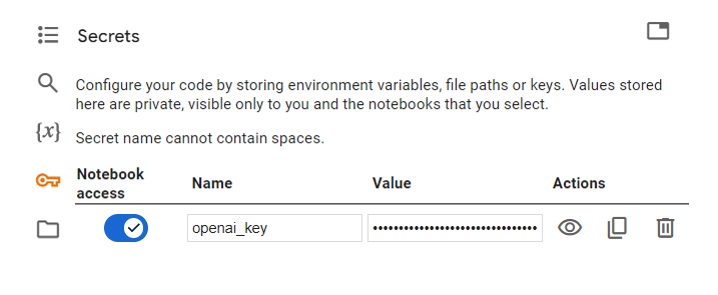


In [2]:
#setup and load your openai key
from openai import OpenAI
from IPython.display import display, HTML
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import csv
import os
from openai import OpenAI
from google.colab import userdata

# Retrieve your OpenAI API key from Google Colab Secrets
openai_key = "sk-"

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_key)
MODEL = 'o1-preview'

print("OpenAI API key set up successfully!")

OpenAI API key set up successfully!


## **Step 3: Load a Toy Dataset of OpenAI Help Center Articles**

We are now going to load a csv file which contains a handful of OpenAI help center articles.  



*   The below cell will grab the articles and load them for you.

*   If you want to check out the contents of the articles visit: https://github.com/openai/openai-cookbook/blob/main/examples/data/helpcenter_articles.csv

*   In the subsequent steps, o1 will convert these into structured instructions, or routines that can be used by (potentially agentic) AI systems to autonomously carry out step-by-step actions

*   This is what the help center csv file looks like




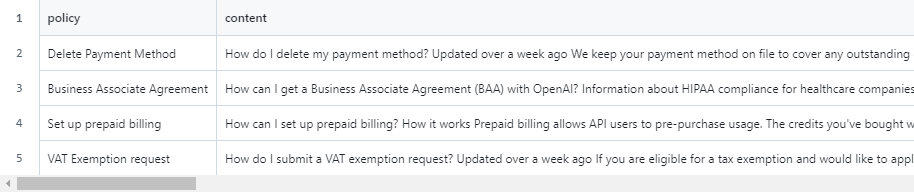

In [3]:
import requests
import csv
from io import StringIO

# URL of the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/openai/openai-cookbook/main/examples/data/helpcenter_articles.csv"

# Fetch the CSV data
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Parse the CSV data
csv_data = StringIO(response.text)
reader = csv.DictReader(csv_data)

# Load the data into a list of dictionaries
articles = []
for row in reader:
    articles.append({
        "policy": row["policy"],
        "content": row["content"]
    })

# Print the first few articles to verify the data
print(f"Loaded {len(articles)} articles.")
print("First few articles:")
for article in articles[:3]:
    print(f"Policy: {article['policy']}")
    print(f"Content: {article['content'][:100]}...")  # Print first 100 characters of content
    print()

Loaded 4 articles.
First few articles:
Policy: Delete Payment Method
Content: How do I delete my payment method?
Updated over a week ago
We keep your payment method on file to co...

Policy: Business Associate Agreement
Content: How can I get a Business Associate Agreement (BAA) with OpenAI?
Information about HIPAA compliance f...

Policy: Set up prepaid billing
Content: How can I set up prepaid billing?

How it works
Prepaid billing allows API users to pre-purchase usa...



## **Step 4: Set the Prompt for o1**

*   This is the prompt/ instructions that o1 will follow to convert the help centre articles into the step-by-step routine

In [4]:
CONVERSION_PROMPT = """
You are a helpful assistant tasked with taking an external facing help center article and converting it into a internal-facing programmatically executable routine optimized for an LLM.
The LLM using this routine will be tasked with reading the policy, answering incoming questions from customers, and helping drive the case toward resolution.

Please follow these instructions:
1. **Review the customer service policy carefully** to ensure every step is accounted for. It is crucial not to skip any steps or policies.
2. **Organize the instructions into a logical, step-by-step order**, using the specified format.
3. **Use the following format**:
   - **Main actions are numbered** (e.g., 1, 2, 3).
   - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
      **Sub-actions should start on new lines**
   - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
   - **For instructions that require more information from the customer**, provide polite and professional prompts to ask for additional information.
   - **For actions that require data from external systems**, write a step to call a function using backticks for the function name (e.g., `call the check_delivery_date function`).
      - **If a step requires the customer service agent to take an action** (e.g., process a refund), generate a function call for this action (e.g., `call the process_refund function`).
      - **Define any new functions** by providing a brief description of their purpose and required parameters.
   - **If there is an action an assistant can performon behalf of the user**, include a function call for this action (e.g., `call the change_email_address function`), and ensure the function is defined with its purpose and required parameters.
      - This action may not be explicitly defined in the help center article, but can be done to help the user resolve their inquiry faster
   - **The step prior to case resolution should always be to ask if there is anything more you can assist with**.
   - **End with a final action for case resolution**: calling the `case_resolution` function should always be the final step.
4. **Ensure compliance** by making sure all steps adhere to company policies, privacy regulations, and legal requirements.
5. **Handle exceptions or escalations** by specifying steps for scenarios that fall outside the standard policy.

**Important**: If at any point you are uncertain, respond with "I don't know."

Please convert the customer service policy into the formatted routine, ensuring it is easy to follow and execute programmatically.

"""

## **Step 5: Run The Prompt and Start The Routine Creation Process**


In [5]:
def generate_routine(policy):
    try:
        messages = [
            {
                "role": "user",
                "content": f"""
                    {CONVERSION_PROMPT}

                    POLICY:
                    {policy}
                """
            }
        ]

        response = client.chat.completions.create(
            model=MODEL,
            messages=messages
        )


        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")

In [6]:
def process_article(article):
    routine = generate_routine(article['content'])
    return {"policy": article['policy'], "content": article['content'], "routine": routine}


with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_article, articles))

## **Step 6: Check The Results**

After the above processes you should see below a three column table (dataframe).

It contains the

*   Original helpcenter article name
*   Original helpcenter article contents
*   The o1 generated routine of step-by-step instructions

As you will see the routines are comprehensive breakdowns of how to action help center related activities, which could potentially be incorporated within a larger agentic AI system to autonomously answer and solve user queries.

Not only are the routines clearly structured as per the original prompt, they also include steps to ask users for clarifying details,  pathing based on interactions, function calls to action or retrieve additional information (e.g.  `call the authenticate_customer function`).

Overall this offers a very helpful starting point for understanding how o1 can be used to rapidly develop and scale automated interactions and actions to help solve customer needs.


In [10]:
df = pd.DataFrame(results)

# Set display options to show all text in the dataframe cells
pd.set_option('display.max_colwidth', None)

# Function to display formatted text in HTML
def display_formatted_dataframe(df):
    def format_text(text):
        return text.replace('\n', '<br>')

    df_formatted = df.copy()
    df_formatted['content'] = df_formatted['content'].apply(format_text)
    df_formatted['routine'] = df_formatted['routine'].apply(format_text)

    display(HTML(df_formatted.to_html(escape=False, justify=None)))

display_formatted_dataframe(df)

## **Step 7: Export Output to CSV**

Saves to Colab temporary files

In [8]:
import pandas as pd
from google.colab import drive

df = pd.DataFrame(results)

# Set display options to show all text in the dataframe cells
pd.set_option('display.max_colwidth', None)

# Define the path where you want to save the CSV file
csv_path = '/content/output.csv'

# Export the DataFrame to a CSV file in the specified Google Drive location
df.to_csv(csv_path, index=False)

print(f"CSV file has been created at: {csv_path}")

CSV file has been created at: /content/output.csv
